In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Arc
from matplotlib.pyplot import figure
from PIL import Image
import scipy.sparse
import scipy.sparse.linalg

# 2

In [2]:
img = Image.open('./cc_90.png')
img = np.array(img.getdata())

# taken from image properties
IMG_WIDTH = 338
IMG_HEIGHT = 250

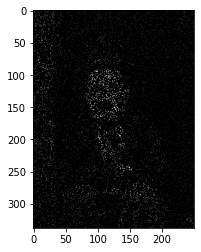

In [3]:
plt.imshow(img.reshape((IMG_WIDTH, IMG_HEIGHT)),cmap='gray', vmin=0, vmax=255)
plt.show()

In [4]:
zero_pixel_count = np.sum(img == 0) / img.shape[0]
print(f"there are {100 * zero_pixel_count:.2f}% missing pixels")

there are 90.00% missing pixels


In [5]:
y = img
X = np.dstack(np.meshgrid(np.arange(IMG_WIDTH), np.arange(IMG_HEIGHT))).reshape(-1, 2)

In [6]:
train_idx = y != 0

X_train = X[train_idx]
y_train = y[train_idx]

# test isnt really a good name for this
X_test = X[~train_idx]

In [7]:
N = len(y_train)
sigma = 5
tau = 5

In [8]:
def K(X1, X2):
    diff = X1 - X2
    axis = len(diff.shape) - 1
    return np.exp(- np.linalg.norm(diff, axis=axis) ** 2 / (2 * sigma ** 2))   

In [9]:
# computing ki requires a lot of RAM and causes the ipy-kernel to die
# to avoid this we split X in half and compute two kis 
# which are then concatenated

halfway_point = len(X_test) // 2
X_test_first_half  = X_test[:halfway_point]
X_test_second_half = X_test[halfway_point:]

ki = np.concatenate([
        K(X_test_first_half[:, None], X_train), 
        K(X_test_second_half[:, None], X_train)])
ki = ki.T

In [10]:
G = K(X_train[:, None], X_train)

In [11]:
G

array([[1.        , 0.08892162, 0.00597602, ..., 0.        , 0.        ,
        0.        ],
       [0.08892162, 1.        , 0.60653066, ..., 0.        , 0.        ,
        0.        ],
       [0.00597602, 0.60653066, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.83527021,
        0.05613476],
       [0.        , 0.        , 0.        , ..., 0.83527021, 1.        ,
        0.1978987 ],
       [0.        , 0.        , 0.        , ..., 0.05613476, 0.1978987 ,
        1.        ]])

### Make G a sparse matrix
By setting all values under a threshold to zero.

In [11]:
for threshold in [0.1 * i for i in range(10, 1, -1)] + [10**-i for i in range(1, 10)]:
    print(f"For a threshold of {threshold:.2}\t{round(1000 * (G < threshold).sum() / (G.shape[0] * G.shape[1]))} in 1000 of G are set to zero")

For a threshold of 1.0	1000 in 1000 of G are set to zero
For a threshold of 0.9	999 in 1000 of G are set to zero
For a threshold of 0.8	998 in 1000 of G are set to zero
For a threshold of 0.7	997 in 1000 of G are set to zero
For a threshold of 0.6	996 in 1000 of G are set to zero
For a threshold of 0.5	995 in 1000 of G are set to zero
For a threshold of 0.4	993 in 1000 of G are set to zero
For a threshold of 0.3	991 in 1000 of G are set to zero
For a threshold of 0.2	989 in 1000 of G are set to zero
For a threshold of 0.1	984 in 1000 of G are set to zero
For a threshold of 0.01	969 in 1000 of G are set to zero
For a threshold of 0.001	954 in 1000 of G are set to zero
For a threshold of 0.0001	940 in 1000 of G are set to zero
For a threshold of 1e-05	926 in 1000 of G are set to zero
For a threshold of 1e-06	913 in 1000 of G are set to zero
For a threshold of 1e-07	900 in 1000 of G are set to zero
For a threshold of 1e-08	887 in 1000 of G are set to zero
For a threshold of 1e-09	874 in 1

In [12]:
# for now let's use 
threshold = 0.999

G[G < threshold] = 0
G += tau
G = scipy.sparse.csr_matrix(G)

In [ ]:
# this step takes for ever
y_test = y_train.T.dot(scipy.sparse.linalg.spsolve(G, ki))

In [30]:
img = img.reshape((IMG_WIDTH, IMG_HEIGHT))
for (row, col), y_val in zip(X_test, y_test):
    img[row, col] = y_val

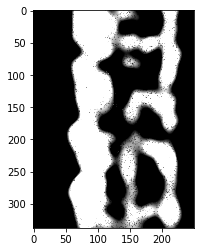

In [32]:
plt.imshow(img,cmap='gray', vmin=0, vmax=255)
plt.show()

# 3

In [ ]:
data = np.load("circles.npy")

In [ ]:
data.min(axis=0), data.max(axis=0)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data.T)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data.T)

color = "black"
linewidth = 5

ax.add_patch(Arc((.448, .52), .65, .65, theta1=130, theta2=235, color=color, linewidth=linewidth))
ax.add_patch(Arc((.74, .67), .5, .5, theta1=80, theta2=190, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.23, .8), .17, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.27, .25), .16, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.65, .32), .3, fill=False, color=color, linewidth=linewidth))
ax.add_patch(plt.Circle((.73, .27), .13, fill=False, color=color, linewidth=linewidth))

plt.show()

In [ ]:
def circle_touching_three_points_vec(points):
    """This adapts the formular outlined here: https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates
    It expects three points in R2, so dim(points) = 3x2
    """
    xs = points[:, :,0]
    ys = points[:, :,1]
    ones = np.ones(list(points.shape)[:2])
    len_squared = np.linalg.norm(points, axis=2) ** 2

    def stack(a, b, c):
        return np.hstack([a, b, c]).reshape((points.shape[0], 3, 3))
    
    
    S_x = .5 * np.linalg.det(stack(len_squared, ys, ones))
    S_y = .5 * np.linalg.det(stack(xs, len_squared, ones))
    a = np.linalg.det(stack(xs, ys, ones))
    b = np.linalg.det(stack(xs, ys, len_squared))
    
    S = np.array([S_x, S_y]).T
    center = S/a[:, None]
    radius = np.sqrt((b / a ) + (np.linalg.norm(S, axis=1) ** 2 / a ** 2))

    return np.vstack([center.T, radius]).T

In [ ]:
def ransac(data, number_of_circles, N, epsilon):
    """
        number_of_circles: number of circles to find
        N: iterations per circle
    """
    best_circles = []
    filtered_out_points = None
    
    for _ in range(number_of_circles):
        R = np.zeros((N, 3, 2))
        M = data.shape[0]
        for i in range(N):
            random_index = np.random.choice(np.arange(M), size=3, replace=True)
            R[i] = data[random_index] 
        C = circle_touching_three_points_vec(R)
        centers = C[:, :2]
        radius = C[:, 2]

        distances_to_centers = np.linalg.norm(data - centers[:, None, :], axis=2)
        distance_to_circle = np.abs(distances_to_centers - radius[:, None])
        close_to_circle = distance_to_circle < epsilon
        inliers = close_to_circle.sum(axis=1)

        best_circle_idx = inliers.argmax()
        best_circle = C[best_circle_idx]
    
        best_circles.append(best_circle)
    
        # filter out all points used to construct the current best circle
        data = data[~close_to_circle[best_circle_idx]]
          
    return best_circles, data

In [ ]:
circles, data_filter = ransac(data, number_of_circles=6, N=10_000, epsilon=0.004)

fig, ax = plt.subplots(figsize=(8,8))

plt.xlim(-0.01, 1.01)
plt.ylim(-0.01, 1.01)
plt.gca().set_aspect('equal', adjustable='box')
ax.scatter(*data_filter.T)

color = "black"
linewidth = 5

for circle in circles:
    center, radius = unpack_center_radius(circle)
    ax.add_patch(plt.Circle(center, radius, fill=False, color=color, linewidth=linewidth))

# plot the points that were used to create the circles
ax.scatter(*data[~(np.isin(data, data_filter))[:, 0]].T)

plt.show()

The result is sensitive to epsilon. When epsilon is too low, not enough points are removed once a circle is found as best circle for one iteration. When epsilon is too high the algorithm just selects large circles that cover a big distances and therefor come near a lot of points. 